Import necessary libraries

In [52]:
from transformers import BertTokenizer, BertForSequenceClassification
from sequence_explainer import NewSequenceClassificationExplainer
import shap
import torch
import torch.nn.functional as F
import transformers
from captum.attr import visualization as viz
import matplotlib.pyplot as plt
import seaborn as sns

Load the model and tokenizer

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained("textattack/bert-base-uncased-imdb").to(device)
tokenizer = BertTokenizer.from_pretrained("textattack/bert-base-uncased-imdb")
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Test the model with a sample sentence

In [16]:
sentences = ["I really love fantasy films."]
print(f"Text inputs: {sentences}")

# **TOKENIZZAZIONE CORRETTA**
inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")  # Convertiamo i testi in tensori
# **SPOSTIAMO I TENSORI SULLA STESSA DEVICE DEL MODELLO**
inputs = {key: value.to(device) for key, value in inputs.items()}

outputs = model(**inputs)  # Otteniamo le predizioni
# **ESTRAGGIAMO LE PREDIZIONI**
logits = outputs.logits  # Otteniamo i logits (punteggi grezzi)
probabilities = F.softmax(logits, dim=-1)  # Applichiamo softmax per ottenere probabilità
predicted_classes = torch.argmax(probabilities, dim=-1).tolist()  # Troviamo la classe con probabilità più alta

# Definizione delle classi, supponendo un mapping delle classi del modello
class_labels = ["Negative", "Positive"]
# Stampa delle classi predette con probabilità
for i, pred in enumerate(predicted_classes):
    predicted_class = class_labels[pred]  # Converte l'indice nella label della classe
    probability = probabilities[i][pred].item()  # Estrae la probabilità della classe predetta
    print(f"Sample {i}: \"{sentences[i]}\" -> Predicted Class: {predicted_class} (Probability: {probability:.4f})")

Text inputs: ['I really love fantasy films.']
Sample 0: "I really love fantasy films." -> Predicted Class: Positive (Probability: 0.9363)


White-box explanations

In [33]:
# Memorizziamo le attribuzioni per ogni frase e tipo di spiegazione
all_attributions = []
explain_types = ["ig", "lig"]
for explain_type in explain_types:
    explainer = NewSequenceClassificationExplainer(model, tokenizer, attribution_type=explain_type)
    
    for sentence in sentences:
        attributions = explainer(sentence)
        # Salva le attribuzioni in una lista
        all_attributions.append({
            "sentence": sentence,
            "explain_type": explain_type,
            "attributions": attributions,
            "pred_prob": probabilities[0, predicted_classes[0]].item(),
            "pred_class": class_labels[predicted_classes[0]]
        })
        # Print the attributions for each token in the sentence. 
        print(f"\nWord attributions for: \"{sentence}\"")
        print(f"Attribution type: {explain_type}")
        for token, score in attributions:
            print(f"{token:>10} : {score:.4f}")


Word attributions for: "I really love fantasy films."
Attribution type: ig
     [CLS] : 0.0000
         i : 0.3577
    really : 0.0381
      love : 0.8381
   fantasy : 0.1266
     films : -0.3356
         . : -0.1985
     [SEP] : 0.0000

Word attributions for: "I really love fantasy films."
Attribution type: lig
     [CLS] : 0.0000
         i : 0.4091
    really : 0.1712
      love : 0.8605
   fantasy : 0.1394
     films : -0.1863
         . : -0.0937
     [SEP] : 0.0000
[{'sentence': 'I really love fantasy films.', 'explain_type': 'ig', 'attributions': [('[CLS]', 0.0), ('i', 0.3577437996864319), ('really', 0.038115132600069046), ('love', 0.8381404876708984), ('fantasy', 0.12660124897956848), ('films', -0.33563828468322754), ('.', -0.19850993156433105), ('[SEP]', 0.0)], 'pred_prob': 0.9363359808921814, 'pred_class': 'Positive'}, {'sentence': 'I really love fantasy films.', 'explain_type': 'lig', 'attributions': [('[CLS]', 0.0), ('i', 0.40908798575401306), ('really', 0.1711611300706863

Black-box Explanation with SHAP

In [45]:
transf_pipeline = transformers.pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1,
    top_k=None,  # Sostituisce return_all_scores=True
)
transf_pipeline = shap.models.TransformersPipeline(transf_pipeline, rescale_to_logits=True)
explainer = shap.Explainer(transf_pipeline)
shap_values = explainer(sentences)
shap_values_normalized = torch.tensor(shap_values.values) / torch.norm(torch.tensor(shap_values.values), dim=1, keepdim=True)
#print("SHAP Explanation:", shap_values.values)
print("SHAP Explanation Normalized:", shap_values_normalized)

explain_types = ["gs"]
for explain_type in explain_types:
    explainer = NewSequenceClassificationExplainer(model, tokenizer, attribution_type=explain_type)
    for sentence in sentences:
        attributions = explainer(sentence)
        all_attributions.append({
            "sentence": sentence,
            "explain_type": explain_type,
            "attributions": attributions,
            "pred_prob": probabilities[0, predicted_classes[0]].item(),
            "pred_class": class_labels[predicted_classes[0]]
        })
        # Print the attributions for each token in the sentence.
        print(f"\nWord attributions for: \"{sentence}\"")
        print(f"Attribution type: {explain_type}")
        for token, score in attributions:
            print(f"{token:>10} : {score:.4f}")

Device set to use cpu


SHAP Explanation Normalized: tensor([[[ 0.0000,  0.0000],
         [-0.0176,  0.0176],
         [-0.3490,  0.3490],
         [-0.8945,  0.8945],
         [ 0.2099, -0.2099],
         [ 0.1809, -0.1809],
         [-0.0313,  0.0313],
         [ 0.0000,  0.0000]]], dtype=torch.float64)

Word attributions for: "I really love fantasy films."
Attribution type: gs
     [CLS] : 0.0000
         i : 0.3318
    really : -0.0920
      love : 0.7590
   fantasy : 0.1742
     films : -0.4416
         . : -0.2829
     [SEP] : 0.0000


Visualization

In [46]:
for entry in all_attributions:
    print(f"\nAttributions for method: \"{entry['explain_type']}\"")
    print(entry['attributions'])
    tokens = [token for token, _ in entry["attributions"]]
    scores = [score for _, score in entry["attributions"]]
    vis_data_records= [viz.VisualizationDataRecord(
            word_attributions=scores,
            pred_prob=entry["pred_prob"],
            pred_class=entry["pred_class"],
            true_class=entry["pred_class"],  # Supponendo che la classe predetta sia corretta
            attr_class=entry["pred_class"],
            attr_score=sum(scores),
            raw_input_ids=tokens,
            convergence_score=0.0,  # Non calcolato in questo contesto
        )]
    # Visualizza le attribuzioni
    viz.visualize_text(vis_data_records)


Attributions for method: "ig"
[('[CLS]', 0.0), ('i', 0.3577437996864319), ('really', 0.038115132600069046), ('love', 0.8381404876708984), ('fantasy', 0.12660124897956848), ('films', -0.33563828468322754), ('.', -0.19850993156433105), ('[SEP]', 0.0)]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Positive,Positive (0.94),Positive,0.83,[CLS] i really love fantasy films . [SEP]



Attributions for method: "lig"
[('[CLS]', 0.0), ('i', 0.40908798575401306), ('really', 0.17116113007068634), ('love', 0.8604824542999268), ('fantasy', 0.13938811421394348), ('films', -0.18629667162895203), ('.', -0.09372986853122711), ('[SEP]', 0.0)]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Positive,Positive (0.94),Positive,1.30,[CLS] i really love fantasy films . [SEP]



Attributions for method: "gs"
[('[CLS]', 0.0), ('i', 0.33177536725997925), ('really', -0.09204816818237305), ('love', 0.7589544653892517), ('fantasy', 0.17420992255210876), ('films', -0.4416426122188568), ('.', -0.28291890025138855), ('[SEP]', 0.0)]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Positive,Positive (0.94),Positive,0.45,[CLS] i really love fantasy films . [SEP]


Shap Visualization

In [47]:
# Visualization with SHAP
def shap_visualization(texts, shap_values):
    shap.initjs()
    for i, text in enumerate(texts):
        print(f"\nSHAP Visualization for: {text}")
        shap.plots.text(shap_values[i])

shap_visualization(sentences, shap_values)


SHAP Visualization for: I really love fantasy films.


Grafici

C:\Users\crist\AppData\Local\Temp\ipykernel_17556\4232741626.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attributions, y=tokens, palette="magma")


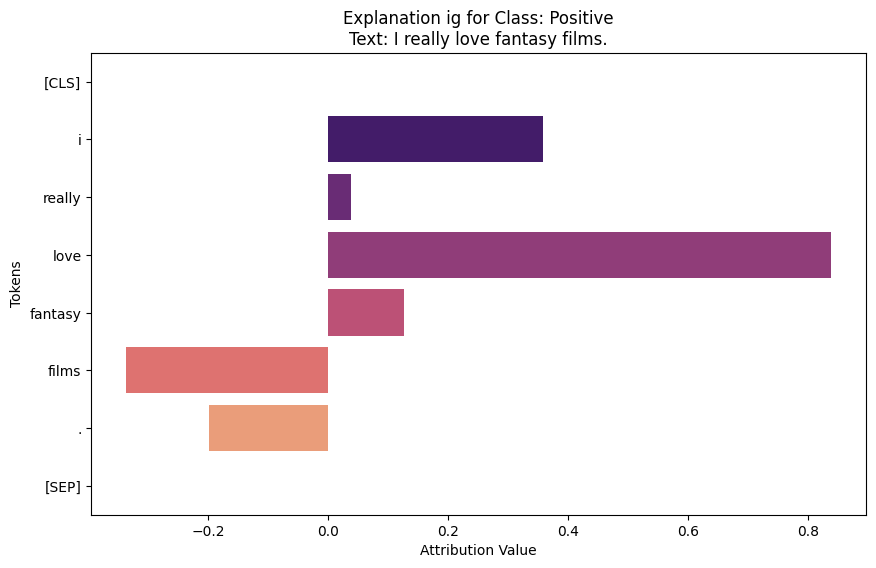

C:\Users\crist\AppData\Local\Temp\ipykernel_17556\4232741626.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attributions, y=tokens, palette="magma")


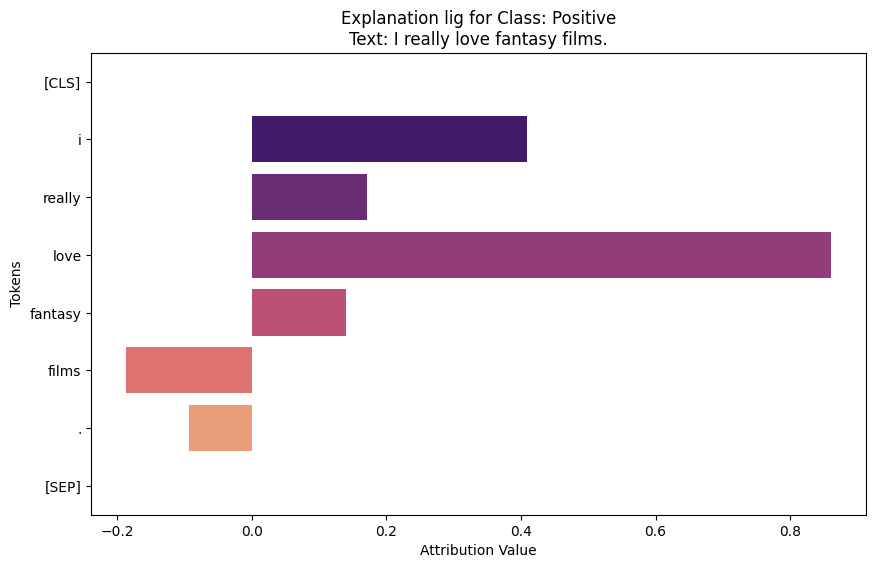

C:\Users\crist\AppData\Local\Temp\ipykernel_17556\4232741626.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attributions, y=tokens, palette="magma")


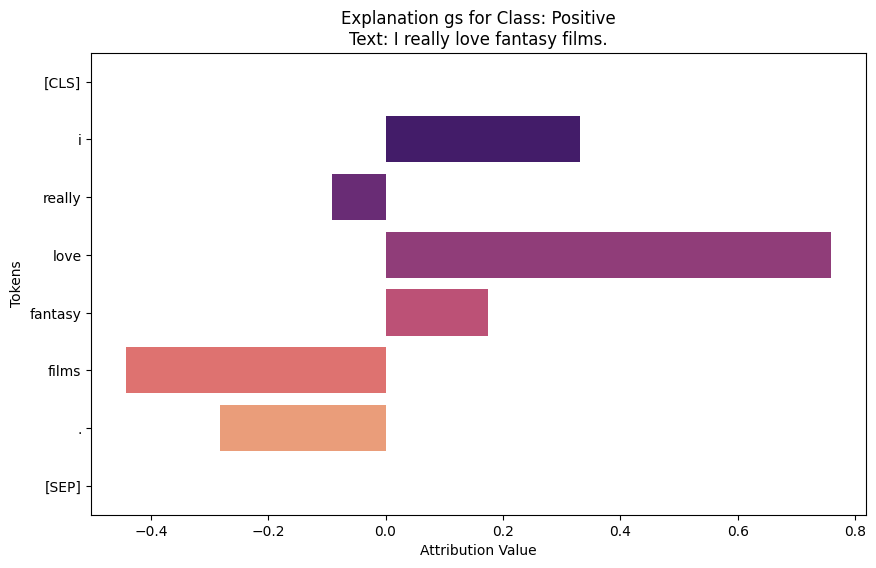

In [54]:
# Funzione per plottare le attribuzioni
def plot_exp_per_classes(all_attributions):
    for entry in all_attributions:
        sentence = entry["sentence"]
        explain_type = entry['explain_type']
        tokens = [token for token, _ in entry["attributions"]]
        attributions = [attribution for _, attribution in entry["attributions"]]
        class_name = entry["pred_class"]  # Classe predetta

        if len(tokens) == len(attributions):
            plt.figure(figsize=(10, 6))
            sns.barplot(x=attributions, y=tokens, palette="magma")
            plt.title(f"Explanation '{explain_type}' for Class: {class_name}\nText: {sentence}")
            plt.xlabel("Attribution Value")
            plt.ylabel("Tokens")
            plt.show()
        else:
            print(f"Warning: Explanation {explain_type} for text '{sentence}' do not match token length.")

# Chiamata alla funzione corretta
plot_exp_per_classes(all_attributions)

Advervsarial examples Explanations